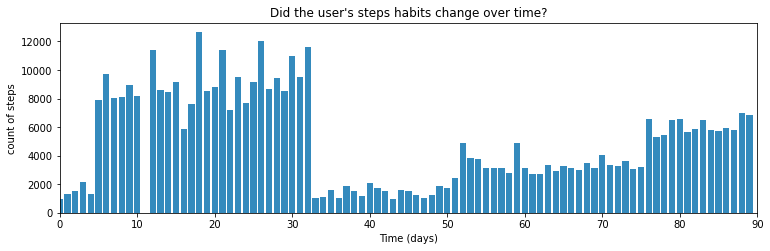

In [15]:
import theano as th
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
import pandas as pd

figsize(11, 9)

import scipy.stats as stats

figsize(12.5, 3.5)
count_data = pd.Series([953, 1291, 1506, 2124, 1335, 7929, 9751,
                        8032, 8085, 8968, 8157, np.nan, 11404, 8585, 
                        8490, 9137, 5881, 7609, 12687, 8537, 8785, 
                        11377, 7166, 9520, 7674, 9157, 12039,8698, 
                        9456, 8547, 10976, 9543, 11589, 1069, 1136, 
                        1571, 1011, 1875, 1523, 1171, 2079, 1722, 
                        1540, 985, 1608, 1505, 1265, 1005, 1240, #1 enero-18 febrero
                        1873, 1743, 2425, 4873, 3829, 3747, 3133,
                        3135, 3102, 2808, #19 feb-28 feb
                        4854, 3163, 2744, 2727, 3331, 2912, 3285, 3150,
                        2966, 3484, 3167, 4012, 3338, 3252, 3627, 3101, 3240,
                        6551, 5303, 5438, 6478, 6553, 5627, 5896, 6474, 5830,
                        5731, 5915, 5776, 6955, 6825#31 marzo
                        
                       ]) 
        
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of steps")
plt.title("Did the user's steps habits change over time?")
plt.xlim(0, n_count_data);

We can see that we should get 4 switchpoints. From my knowledge, these would correspond to: the day I finish my lockdown, the day I had the acciddent and broke my bone, the day they took off the cast and when I could start walking. 

In [16]:
def create_steps_model(n_switchpoints):
    with pm.Model() as model:
        def create_switchpoint(id, lower, upper):
            return pm.DiscreteUniform(f'switchpoint_{id}', lower=lower, upper=upper)

        def create_rate(id, lower, upper):
            return pm.Uniform(f'rate_{id}', lower=lower, upper=upper) #average as a free parameter

        def build_switch(id):
            if id == 0:
                return pm.math.switch(switchpoints[0] >= days, rates[id], rates[id+1])
            else:
                return pm.math.switch(switchpoints[id] >= days, build_switch(id-1), rates[id+1])

        switchpoints = [create_switchpoint(0, 0, 10)] #len(count_data) - n_switchpoints)
        for i in range(1, n_switchpoints):
            switchpoints.append(create_switchpoint(i, switchpoints[i-1]+1, len(count_data)-n_switchpoints+i)) 
            #Quitando el lower=switchpoints[i-1]+1 aparece el primer switch, pero la esstadística va peor

        rates = []
        for i in range(0, n_switchpoints+1):
            rates.append(create_rate(i, 0, 13000))

        days = np.arange(0, len(count_data))
        variance = pm.Uniform('variance', 1, 100)#Para la binomial negativa no es la varianza, es el parámetro shape de una distribución gamma 

        rate = build_switch(n_switchpoints-1)

        #observation = pm.Poisson('obs', rate, observed=count_data) #gaussian distribution of data
        observation = pm.NegativeBinomial('obs', rate, variance, observed=count_data)
                    #como una distribución de poisson con rate lambda donde lambda es un número que se saca de una distribución gamma
    
    return model   

In [17]:
with create_steps_model(4) as model:
    trace = pm.sample(10000, tune = 5000, return_inferencedata=True)


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/model.py:1755: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [obs_missing]
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_4, rate_3, rate_2, rate_1, rate_0]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 24 seconds.
/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 25% for some parameters.


In [18]:
az.summary(trace, hdi_prob=.95) #Al no tener error el switchpoint 0 y 1 sale NaN

/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint_0,4.000,0.000,4.000,4.000,0.000,0.000,40000.0,40000.0,NaN
switchpoint_1,32.000,0.000,32.000,32.000,0.000,0.000,40000.0,40000.0,NaN
switchpoint_2,50.036,0.252,50.000,51.000,0.004,0.003,5012.0,4281.0,1.0
switchpoint_3,74.989,0.114,75.000,75.000,0.002,0.001,5055.0,7097.0,1.0
obs_missing[0],9208.788,1685.532,5951.000,12498.000,18.559,13.318,8402.0,9484.0,1.0
rate_0,1461.338,123.206,1230.774,1710.762,0.491,0.353,64511.0,30504.0,1.0
rate_1,9200.464,324.438,8573.454,9841.779,1.536,1.091,45075.0,30823.0,1.0
rate_2,1447.894,64.855,1324.686,1578.355,0.311,0.222,44428.0,29875.0,1.0
rate_3,3346.113,124.230,3111.487,3598.701,0.494,0.351,63709.0,31425.0,1.0
rate_4,6123.920,303.439,5536.292,6720.328,1.259,0.895,58567.0,31992.0,1.0


We got a good convergence of the model. For the first and second switchpoints we had no erro, getting a NaN (not a number) R hat result.

\pagebreak

array([[<AxesSubplot:title={'center':'variance'}>,
        <AxesSubplot:title={'center':'variance'}>]], dtype=object)

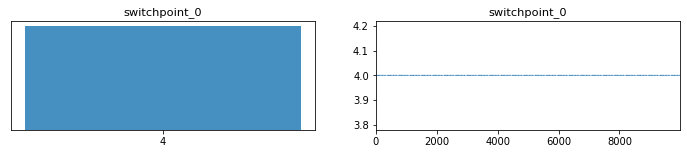

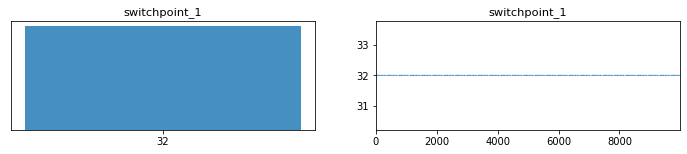

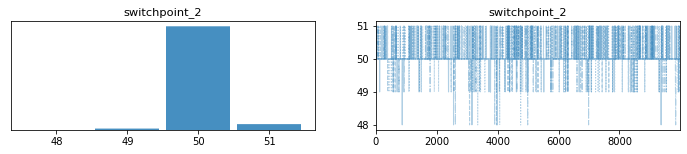

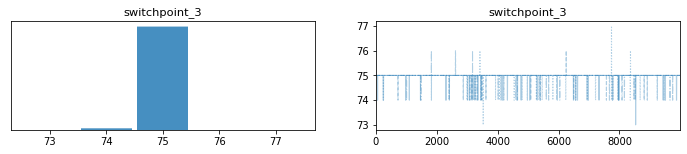

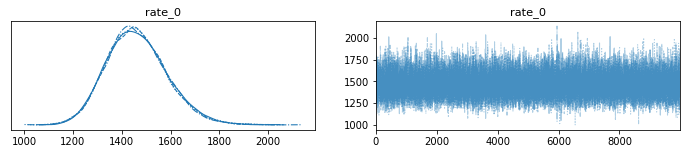

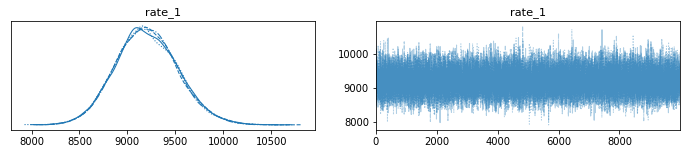

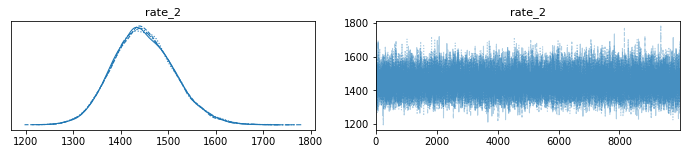

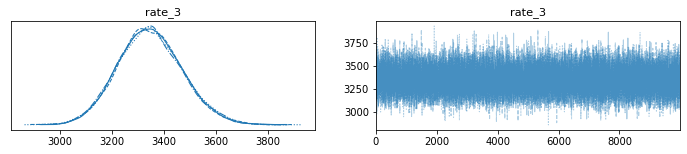

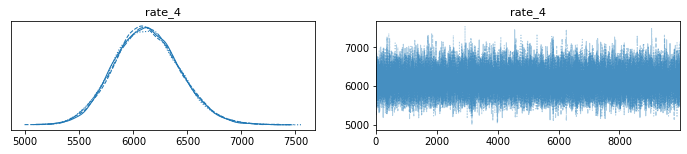

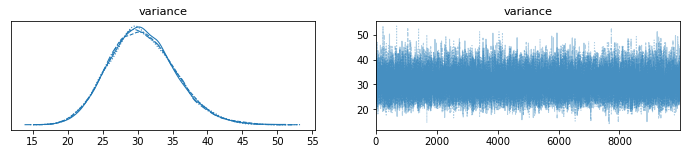

In [19]:

az.plot_trace(trace,var_names="switchpoint_0")
az.plot_trace(trace,var_names="switchpoint_1")
az.plot_trace(trace,var_names="switchpoint_2")
az.plot_trace(trace,var_names="switchpoint_3")
az.plot_trace(trace,var_names="rate_0")
az.plot_trace(trace,var_names="rate_1")
az.plot_trace(trace,var_names="rate_2")
az.plot_trace(trace,var_names="rate_3")
az.plot_trace(trace,var_names="rate_4")
az.plot_trace(trace,var_names="variance")



Let's see the evolution:

In [20]:
with create_steps_model(4) as model:
        prediction=pm.sample_posterior_predictive(trace, 10000)

/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/model.py:1755: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [21]:
def layout (n_switchpoints):
    plot_dates =  np.arange(0, len(count_data))
    
    posterior_quantile = np.percentile(prediction["obs"], [2.5, 25, 50, 75, 97.5], axis=0)

    # Plot daily number of steps
    plt.plot(
        plot_dates, posterior_quantile[2, :],
        color='b', label='posterior median', lw=2)

    plt.fill_between(
        plot_dates, posterior_quantile[0, :], posterior_quantile[4, :],
        color='b', label='95% quantile', alpha=.2)

    plt.plot(
          plot_dates, count_data,
          '--o', color='k', markersize=3,
          label='Observed', alpha=.8)

    for j in range(0, n_switchpoints):
        plt.vlines(np.median(trace["posterior"]["switchpoint_%s" %(j)]), count_data.min(), count_data.max(), color='C1')

    plt.xticks(np.arange(min(plot_dates), max(plot_dates), 7), rotation=30)
    plt.ylabel('Steps', fontsize='large')
    plt.xlabel('Day', fontsize='large')
    plt.title('With %s switchpoints'%n_switchpoints)

    fontsize = 'medium'
    plt.legend(loc='upper left', fontsize=fontsize)

    return plt.tight_layout();


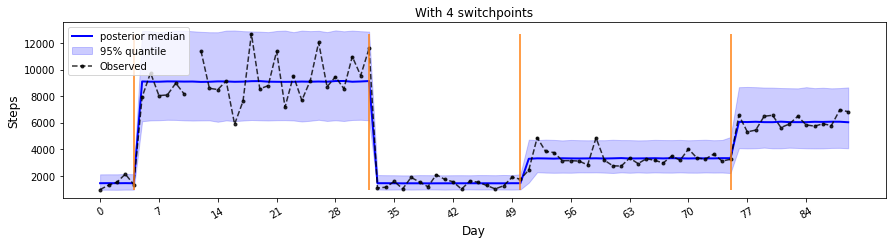

In [22]:
layout(4)

The medians of each switchpoint distribution are plotted with an orange vertical line. These results show a correlation with the four switchpoints I expected: the day I finish my lockdown, the day I had the acciddent and broke my bone, the day they took off the cast and when I could start walking. 